# Pretrained ResNet-18

## Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
from torchvision.io import read_image
import torchvision.transforms as transforms
from tqdm.notebook import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using:', device)

Using: cuda


In [2]:
TRAIN_FOLDER_PATH = "C:/Users/rjrao/Downloads/Chest_Xray_dataset/train"
TEST_FOLDER_PATH = "C:/Users/rjrao/Downloads/Chest_Xray_dataset/test"

## Exploring the data
This dataset contains 5,856 validated Chest X-Ray images. The images are split into a training set and a testing set of independent patients. <br/>
Images are labeled as NORMAL (healthy patient) and PNEUMONIA (sick patient). <br/>
There are 5232 training examples in total :- 1349 of NORMAL and 3883 of PNEUMONIA classes  <br/>
There are 624 testing examples in total :- 234 of NORMAL and 390 of PNEUMONIA classes

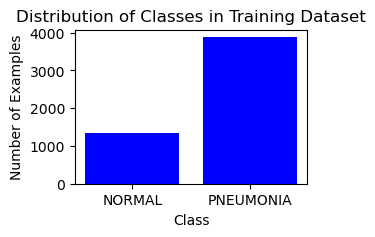

Total examples in Training dataset: 5232
Class-wise counts:
NORMAL: 1349
PNEUMONIA: 3883


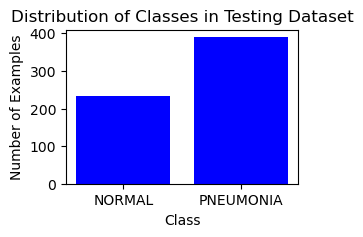

Total examples in Testing dataset: 624
Class-wise counts:
NORMAL: 234
PNEUMONIA: 390


In [3]:
def explore_dataset(folder_path, dataset_type):
    class_counts = {}
    total_samples = 0

    # Iterate through each class folder
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            num_samples = len(os.listdir(class_folder))
            class_counts[class_name] = num_samples
            total_samples += num_samples

    # Plot the results
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(3, 2))
    plt.bar(classes, counts, color='blue')
    plt.title(f'Distribution of Classes in {dataset_type} Dataset')
    plt.xlabel('Class')
    plt.ylabel('Number of Examples')
    plt.show()

    print(f"Total examples in {dataset_type} dataset: {total_samples}")
    print("Class-wise counts:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count}")

# Explore the training dataset
explore_dataset(TRAIN_FOLDER_PATH, "Training")

# Explore the testing dataset
explore_dataset(TEST_FOLDER_PATH, "Testing")

## Loading Pretrained ResNet-18
Here we are loading a pre-trained ResNet-18 model that was trained on ImageNet dataset.
https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html  </br>
After loading the pretrained ResNet-18, we are removing the last fully connected layer and adding our own new fully connected layer for classification.

In [4]:
class PretrainedResNet18(nn.Module):
    def __init__(self, n_classes):
        super(PretrainedResNet18, self).__init__()

        # Load pre-trained ResNet-18 model
        resnet18 = torchvision.models.resnet18(pretrained=True)
        
        # Remove the fully connected layer at the end
        self.features = nn.Sequential(*list(resnet18.children())[:-1])
        
        for param in resnet18.parameters():
            param.requires_grad = False
        
        self.fc = nn.Linear(resnet18.fc.in_features, n_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

## Loading Dataset 
We will be using the ImageFolder function from torchvision.datasets to create a dataset and split it into training and validation sets, then create DataLoader for Training and Validation datasets.

In [5]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.ImageFolder(root = TRAIN_FOLDER_PATH, transform = train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root = TEST_FOLDER_PATH, transform = train_transforms)

n_classes = len(set(train_dataset.targets))
train, val = torch.utils.data.random_split(train_dataset, [4000, 5232-4000])

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val, batch_size=64, shuffle=True)

## Initializing Model
First we will initialize our model with the number of classes in our dataset. <br/>
Then we will define a loss function and optimizer for our model, in this case we will use the Cross Entropy loss and Adam optimizer with default parameters. </br></br>
Another modification is adding weights as inverse class frequencies to the cross entropy loss calculation. This is done to address class imbalance problem. </br>
Class imbalance occurs when certain classes in a dataset have significantly fewer examples than others, potentially leading the model to be biased towards the majority class during training. </br></br>
Class NORMAL (1349) :- inverse class frequency = 1-(1349/5232) = 0.74 </br>
Class PNEUMONIA (3883) :- inverse class frequency = 1-(3883/5232) = 0.26

In [6]:
# CONFIGURING MODEL PARAMETES
n_batches = len(train_loader)

model = PretrainedResNet18(n_classes=n_classes).to(device)
weight=torch.Tensor([0.74,0.26]).to(device)
criterion = nn.CrossEntropyLoss(weight=weight)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
print(model)

C:\Users\rjrao\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\rjrao\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


PretrainedResNet18(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

## Training the model

In [7]:
epochs = 10

for epoch in range(epochs):
    loss_list = []
    num_correct, num_samples = 0, 0
    for batch_num, (images, labels) in tqdm(enumerate(train_loader), total = n_batches):
        images = images.to(device)
        labels = labels.to(device)
        
        predictions = model(images)
        loss = criterion(predictions, labels)
        loss_list.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, train_predictions = predictions.max(1)
        num_correct += (train_predictions==labels).sum()
        num_samples += predictions.size(0)
    
    training_accuracy = float(num_correct)/float(num_samples)*100 
    
    val_loss_list = []
    val_num_correct, val_num_samples = 0, 0
    model.eval()
    with torch.no_grad():
        for val_batch_num, (val_images, val_labels) in enumerate(val_loader):
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            val_predictions = model(val_images)
            _, val_preds = val_predictions.max(1)
            
            val_num_correct += (val_preds==val_labels).sum()
            val_num_samples += val_preds.size(0)
            
            val_loss_list.append(criterion(val_predictions, val_labels))
        
    val_accuracy = float(val_num_correct)/float(val_num_samples)*100
    model.train()

    print(f'Epoch: {epoch + 1} | Accuracy: {training_accuracy:.2f} | loss: {sum(loss_list)/len(loss_list)}', end='')
    print(f' | Validation Accuracy: {val_accuracy:.2f} | Validation loss: {sum(val_loss_list)/len(val_loss_list)}')

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 1 | Accuracy: 69.47 | loss: 0.5932580232620239 | Validation Accuracy: 84.50 | Validation loss: 0.5343408584594727


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 2 | Accuracy: 86.42 | loss: 0.43541237711906433 | Validation Accuracy: 89.77 | Validation loss: 0.3800342381000519


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 3 | Accuracy: 89.72 | loss: 0.3516639471054077 | Validation Accuracy: 89.45 | Validation loss: 0.3176938593387604


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 4 | Accuracy: 90.22 | loss: 0.3088033199310303 | Validation Accuracy: 91.80 | Validation loss: 0.28444424271583557


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 5 | Accuracy: 90.67 | loss: 0.27856865525245667 | Validation Accuracy: 90.75 | Validation loss: 0.2523045539855957


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 6 | Accuracy: 91.00 | loss: 0.2584778964519501 | Validation Accuracy: 90.75 | Validation loss: 0.23583069443702698


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 7 | Accuracy: 91.77 | loss: 0.24413563311100006 | Validation Accuracy: 91.07 | Validation loss: 0.22326961159706116


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 8 | Accuracy: 92.00 | loss: 0.225778728723526 | Validation Accuracy: 91.96 | Validation loss: 0.21412821114063263


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 9 | Accuracy: 91.88 | loss: 0.22139227390289307 | Validation Accuracy: 91.31 | Validation loss: 0.2101617306470871


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 10 | Accuracy: 92.20 | loss: 0.20983298122882843 | Validation Accuracy: 92.53 | Validation loss: 0.19449646770954132


## Testing the model

In [8]:
test_num_correct, test_num_samples = 0, 0
test_loss_list = []

model.eval()  
with torch.no_grad():
    for test_batch_num, (test_images, test_labels) in enumerate(test_loader):
        test_images = test_images.to(device)
        test_labels = test_labels.to(device)

        test_predictions = model(test_images)
        _, test_preds = test_predictions.max(1)

        test_num_correct += (test_preds == test_labels).sum().item()
        test_num_samples += test_preds.size(0)

        test_loss_list.append(criterion(test_predictions, test_labels))

test_accuracy = float(test_num_correct) / float(test_num_samples) * 100
average_test_loss = sum(test_loss_list) / len(test_loss_list)

print(f'Test Accuracy: {test_accuracy:.2f} | Test Loss: {average_test_loss}')


Test Accuracy: 89.58 | Test Loss: 0.31799551844596863
